In [2]:
from datasets import load_dataset
ds = load_dataset("fcakyon/crack-instance-segmentation", name="full")

Using the latest cached version of the module from /Users/mansur/.cache/huggingface/modules/datasets_modules/datasets/fcakyon--crack-instance-segmentation/b2a9c7234bb5c0c2ae0848d88193e1571d2344a33489d7b14b906b4539ab1dd8 (last modified on Sat Feb 10 08:11:45 2024) since it couldn't be found locally at fcakyon/crack-instance-segmentation., or remotely on the Hugging Face Hub.
Found cached dataset crack-instance-segmentation (/Users/mansur/.cache/huggingface/datasets/fcakyon___crack-instance-segmentation/full/1.0.0/b2a9c7234bb5c0c2ae0848d88193e1571d2344a33489d7b14b906b4539ab1dd8)


  0%|          | 0/3 [00:00<?, ?it/s]

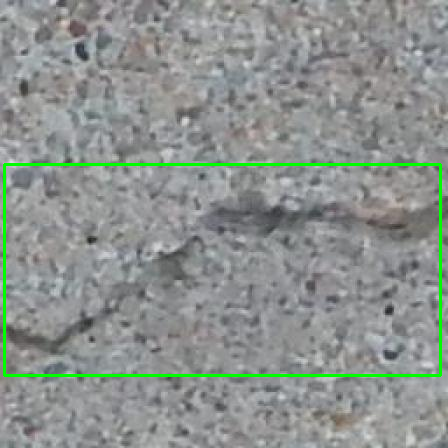

In [12]:

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


def visualize_bboxes(image, pred_bboxes, true_bboxes):
    """
    Visualizes the first bounding box the predicted and ground truth image.
    
    Parameters:
    - image: The input image as a PIL image.
    - pred_bboxes: Predicted bounding boxes as a list of [x_min, y_min, x_max, y_max].
    - true_bboxes: Ground truth bounding boxes as a list of [x_min, y_min, x_max, y_max].
    """
    
    # Convert PIL image to numpy array for OpenCV
    image_np = np.array(image)
    image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR

    start_point = (int(pred_bboxes[0]), int(pred_bboxes[1]))
    end_point = (int(pred_bboxes[0]+pred_bboxes[2]), int(pred_bboxes[1]+pred_bboxes[3]))
    image_np = cv2.rectangle(image_np, start_point, end_point, (255, 0, 0), 2)  # Blue for predicted

    start_point = (int(true_bboxes[0]), int(true_bboxes[1]))
    end_point = (int(true_bboxes[0]+true_bboxes[2]), int(true_bboxes[1]+true_bboxes[3]))
    image_np = cv2.rectangle(image_np, start_point, end_point, (0, 255, 0), 2)  # Green for ground truth

    # Convert back to RGB for matplotlib
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    
    return Image.fromarray(image_np)

#plotting the image
an_example = ds['train'][10]
visualize_bboxes(an_example['image'], an_example['objects']['bbox'][0], an_example['objects']['bbox'][0])

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BoundingBoxRegressionNetwork(nn.Module):
    
    def __init__(self):
        super(BoundingBoxRegressionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 110 * 110, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 4)  # Output 4 values for the bounding box

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))        
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 110 * 110)  
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X) 
        return X


In [18]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.dataloader import default_collate

class BoundingBoxDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (dict): Dictionary containing 'train' and 'test' datasets.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]['image']
        bbox = torch.tensor(self.data[idx]['objects']['bbox'][0])  #only the first bbox
        
        if self.transform:
            image = self.transform(image)
        
        return image, bbox
    
def collate_fn(batch):
    images = [item[0] for item in batch]  # Extract images
    bboxes = [item[1] for item in batch]  # Extract bounding boxes    
    images = default_collate(images)  # Use PyTorch's default collate to process the images        
    
    return images, bboxes
    
    
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize images to 448x448 (if needed)
    transforms.ToTensor(),          # Convert PIL images to tensors
])

train_dataset = BoundingBoxDataset(ds['train'], transform=transform)
test_dataset = BoundingBoxDataset(ds['validation'], transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
import wandb
from torch.nn import SmoothL1Loss
import torch.optim as optim

def save_checkpoint(model, optimizer, epoch, iteration, filepath="checkpoint.pth"):
    """
    Save a model checkpoint.
    
    Parameters:
    - model: The model whose state to save.
    - optimizer: The optimizer whose state to save.
    - epoch: The current epoch number.
    - iteration: The current iteration number.
    - filepath: The path to save the checkpoint to.
    """
    checkpoint = {
        'epoch': epoch,
        'iteration': iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    
def load_checkpoint(filepath, model, optimizer):
    """
    Load a model checkpoint.
    
    Parameters:
    - filepath: The path to the checkpoint.
    - model: The model to load the state into.
    - optimizer: The optimizer to load the state into.
    
    Returns:
    - epoch: The epoch at which training was saved.
    - iteration: The iteration at which training was saved.
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    iteration = checkpoint['iteration']
    return epoch, iteration

# Now you can continue training from the loaded epoch and iteration
    

wandb.init(project="crack-bb-detection", entity="mansurarief")

model = BoundingBoxRegressionNetwork()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = SmoothL1Loss()
model.train()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


test_loss,▁▃▁▁█
train_loss,█▁▁▁▁▁
test_loss,7079.23246
train_loss,29379.37588


BoundingBoxRegressionNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=193600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
)

In [30]:
def save_checkpoint(model, optimizer, epoch, filepath="checkpoint.pth"):
    """
    Save a model checkpoint.
    
    Parameters:
    - model: The model whose state to save.
    - optimizer: The optimizer whose state to save.
    - epoch: The current epoch number.
    - iteration: The current iteration number.
    - filepath: The path to save the checkpoint to.
    """
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, filepath)
    
def load_checkpoint(filepath, model, optimizer):
    """
    Load a model checkpoint.
    
    Parameters:
    - filepath: The path to the checkpoint.
    - model: The model to load the state into.
    - optimizer: The optimizer to load the state into.
    
    Returns:
    - epoch: The epoch at which training was saved.
    - iteration: The iteration at which training was saved.
    """
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [34]:
import tqdm
num_epochs = 1500

for epoch in tqdm.trange(351, num_epochs):    
    model.train()
    train_loss = 0.0
    j = 0
    for images, targets in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        batch_loss = 0.0

        for i, image in enumerate(images):
            image = image.unsqueeze(0) 
            predictions = model(image)
            
            target = targets[i].to(device)
            loss = loss_function(predictions, target.unsqueeze(0))
            batch_loss += loss.item()
            loss.backward()
        
        optimizer.step()
        train_loss += batch_loss
        
        if j == 0:  # Visualize the first image in the batch
            image = images[0].cpu().data 
            pred_bboxes = predictions[0].cpu().detach().numpy()  
            true_bboxes = targets[0].cpu().detach().numpy() 
            vis_image = visualize_bboxes(transforms.ToPILImage()(image), pred_bboxes, true_bboxes)
            
        j += 1
        
    # print(f"Epoch {epoch+1}, Train Loss: {train_loss / len(train_loader)}")
    wandb.log({"train_loss": train_loss, "Training Pred vs True Bboxes": [wandb.Image(vis_image, caption=f"Epoch {epoch+1}")]})
    
    
    
    # Run validation        
    model.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # No gradients needed for evaluation
        j = 0
        for images, targets in test_loader:
            images = images.to(device)
            batch_loss = 0.0

            for i, image in enumerate(images):
                image = image.unsqueeze(0)  # Add batch dimension
                predictions = model(image)

                target = targets[i].to(device)
                loss = loss_function(predictions, target.unsqueeze(0))
                batch_loss += loss.item()
            
            if j == 0:  # Visualize the first image in the batch
                image = images[0].cpu().data  
                pred_bboxes = predictions[0].cpu().detach().numpy()  
                true_bboxes = targets[0].cpu().detach().numpy()  
                vis_image = visualize_bboxes(transforms.ToPILImage()(image), pred_bboxes, true_bboxes)
            j += 1
            
            
            
            test_loss += batch_loss

    # print(f"Epoch {epoch+1}, Test Loss: {test_loss / len(test_loader)}")
    wandb.log({"test_loss": test_loss, "Test Pred vs True Bboxes": [wandb.Image(vis_image, caption=f"Epoch {epoch+1}")]})
    
    if (epoch+1) % 50 == 0:
        save_checkpoint(model, optimizer, 50, f"checkpoint_epoch_{epoch+1}.pth")    




  0%|          | 0/1149 [00:00<?, ?it/s]

100%|██████████| 1149/1149 [10:41:39<00:00, 33.51s/it] 


In [33]:
epoch

355